In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
reward_map = [
    [3., 3.], #CC
    [5., 0.], #DC
    [0., 5.], #CD
    [1., 1.]  #DD
]
reward_map = np.array(reward_map)

In [3]:
def list_to_str(in_list):
    out = ""
    for tmp_v in in_list:
        out = out + str(tmp_v)
    return out

In [4]:
'''
Creating a matrix \overline{M}(s, a', s')
'''
def create_q_func_mat(_M, n_state=16, n_action=4):
    tmp_M = np.copy(_M)
    for i in range(n_state):
        for j in range(n_action):
            tmp_M[i*n_action+j, i] = 0.0
    return tmp_M

def create_initial_mat(_M, n_state=16, n_action=4):
    tmp_M = np.copy(_M)
    for i in range(n_state):
        for j in range(n_action):
            tmp_M[i*n_action+j, i] = 1.0
    return tmp_M

In [5]:
def compute_intrisic_rewards(q_M, n_state=16, n_action=4):
    out_vec = np.zeros(n_state)
    for i in range(n_state):
        tmp_v = 0.0
        for j in range(n_action):
            tmp_v = tmp_v + np.sum(q_M[n_action*i + j])
        out_vec[i] = tmp_v
    return out_vec

In [6]:
def create_q_values(M, n_state=16, n_action=4):
    q_M = create_q_func_mat(M, n_state=n_state, n_action=n_action)
    int_rwds = compute_intrisic_rewards(q_M, n_state=n_state, n_action=n_action)
    q_vals = []
    for i in range(n_state*n_action):
        q_vals.append(np.dot(q_M[i,:], int_rwds))
    q_vals = np.array(q_vals).reshape(n_state, n_action)
    return q_vals

In [7]:
def compute_mean_action_sr(M, obs_id, n_state=4**5, n_action=2):
    out_vec = np.zeros(n_state)
    for i in range(n_action):
        out_vec = out_vec + M[obs_id*n_action+i, :]
    out_vec = out_vec / float(n_action)
    return out_vec

In [8]:
def softmax(a, beta=1.0):
    c = np.max(a)
    exp_a = np.exp(a*beta)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

# N = 2

## SR Empowerment vs TFT

In [9]:
game_history = []
error_history = []
memory = []
num_memory = 2
n_games = 1000000

lr = 0.1
gamma = 0.6

beta = 1.0

n_state=4**num_memory
n_action=2

M = np.zeros((n_state*2, n_state))
M = create_initial_mat(M, n_state=n_state, n_action=n_action)

In [10]:
# a1_action = np.random.choice([0, 1], p=softmax(q_vals[tmp_obs,:], beta=1.0))

cur_obs = None
next_obs = None
cur_action = None
next_action = None
for i in range(n_games):
    ## action of agent2 (Tit for Tat)
    if i%100000 == 0:
        print("episode", i)
    if i == 0:
        a2_action = 0 ## c
    else:
        a2_action = memory[-1][0]
    ## action of agent1
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q_vals = create_q_values(M, n_state=4**num_memory, n_action=2)
        a1_action = np.random.choice([0, 1], p=softmax(q_vals[cur_obs,:], beta=beta))
#         if i > 1000:
#             a1_action = np.random.choice([0, 1], p=softmax(q_vals[cur_obs,:], beta=beta))
#         else:
#             a1_action = np.random.randint(0, 2)
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        if i > 100:
            current_act_idx = 2*cur_obs+a1_action
            next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
            next_sr_vec = compute_mean_action_sr(M, next_obs, n_state=n_state, n_action=2)
            td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M[current_act_idx, :]
            error_history.append(np.mean(td_err))
            M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
    game_history.append(a1_action+(2*a2_action))

episode 0
episode 100000
episode 200000
episode 300000
episode 400000
episode 500000
episode 600000
episode 700000
episode 800000
episode 900000


<Figure size 432x288 with 0 Axes>

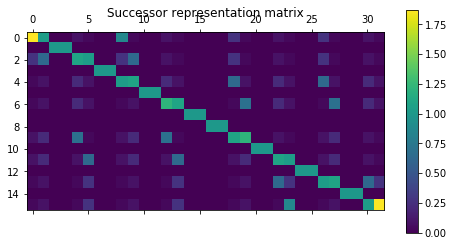

In [11]:
plt.figure()
plt.matshow(M.T)
plt.colorbar()
plt.title("Successor representation matrix")
plt.show()

In [12]:
q_arr = create_q_values(M, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(4), softmax(q_arr[i], beta=beta), s_vals[i])

0000 [0.08989726 0.91010274] 2.893612499999983
0001 [0.5 0.5] 0.0
0010 [0.46139946 0.53860054] 3.8341124999999785
0011 [0.5 0.5] 0.0
0100 [0.39620811 0.60379189] 3.654112499999979
0101 [0.5 0.5] 0.0
0110 [0.41622006 0.58377994] 3.6046124999999796
0111 [0.5 0.5] 0.0
1000 [0.5 0.5] 0.0
1001 [0.58377994 0.41622006] 3.6046124999999796
1010 [0.5 0.5] 0.0
1011 [0.60379189 0.39620811] 3.654112499999979
1100 [0.5 0.5] 0.0
1101 [0.53860054 0.46139946] 3.8341124999999785
1110 [0.5 0.5] 0.0
1111 [0.91010274 0.08989726] 2.893612499999983


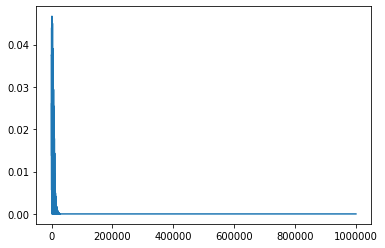

In [13]:
plt.plot(range(len(error_history)), error_history)

<Figure size 720x720 with 0 Axes>

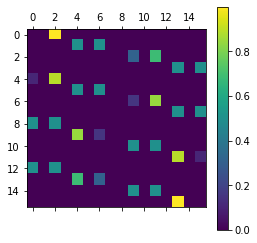

In [19]:
tran_mat = []
for i in range(len(q_arr)):
    tran_vec = np.zeros((1, len(q_arr)))
    prev_state = format(i,'b').zfill(4)[2:]
    for j in [0, 1]:
        k = int(prev_state[0])
        next_state = int(prev_state + str(j) + str(k), 2)
        tran_vec[0, next_state] = softmax(q_arr[i], beta=5)[j]
    tran_mat.append(tran_vec)
tran_mat = np.concatenate(tran_mat)

plt.figure(figsize=(10, 10))
plt.matshow(tran_mat)
plt.colorbar()

In [109]:
softmax(np.array([241.98060756, 245.27679208]), beta=beta)

array([0.27113823, 0.72886177])

## SR Empowerment vs SR Empowerment

In [20]:
game_history = []
error_history1 = []
error_history2 = []
memory = []
num_memory = 2
n_games = 1000000

lr = 0.1
gamma = 0.6

beta = 2.0

n_state=4**num_memory
n_action=2

M1 = np.zeros((n_state*2, n_state))
M1 = create_initial_mat(M1, n_state=n_state, n_action=n_action)
M2 = np.zeros((n_state*2, n_state))
M2 = create_initial_mat(M2, n_state=n_state, n_action=n_action)

In [21]:
cur_obs = None
next_obs = None
cur_action = None
next_action = None
s1_mat = []
s2_mat = []
for i in range(n_games):
    if i%100000 == 0:
        print("episode", i)
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        a2_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q1_vals = create_q_values(M1, n_state=4**num_memory, n_action=2)
        q2_vals = create_q_values(M2, n_state=4**num_memory, n_action=2)
        s1_mat.append(np.mean(q1_vals, axis=1).reshape(1, -1))
        s2_mat.append(np.mean(q2_vals, axis=1).reshape(1, -1))
        a1_action = np.random.choice([0, 1], p=softmax(q1_vals[cur_obs,:], beta=beta))
        a2_action = np.random.choice([0, 1], p=softmax(q2_vals[cur_obs,:], beta=beta))
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        if i > 100:
            ## M1
            current_act_idx = 2*cur_obs+a1_action
            next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
            next_sr_vec = compute_mean_action_sr(M1, next_obs, n_state=n_state, n_action=2)
            td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M1[current_act_idx, :]
            error_history1.append(np.mean(td_err))
            M1[current_act_idx, :] = M1[current_act_idx, :] + lr*td_err
            ## M2
            current_act_idx = 2*cur_obs+a2_action
            next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
            next_sr_vec = compute_mean_action_sr(M2, next_obs, n_state=n_state, n_action=2)
            td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M2[current_act_idx, :]
            error_history2.append(np.mean(td_err))
            M2[current_act_idx, :] = M2[current_act_idx, :] + lr*td_err
    game_history.append(a1_action+(2*a2_action))
s1_mat = np.concatenate(s1_mat, axis=0)
s2_mat = np.concatenate(s2_mat, axis=0)

episode 0
episode 100000
episode 200000
episode 300000
episode 400000
episode 500000
episode 600000
episode 700000
episode 800000
episode 900000


<Figure size 432x288 with 0 Axes>

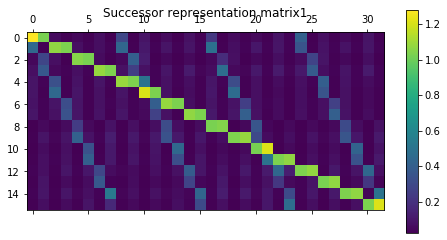

<Figure size 432x288 with 0 Axes>

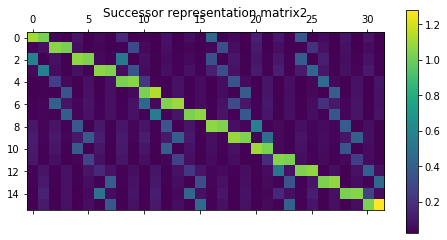

In [22]:
plt.figure()
plt.matshow(M1.T)
plt.colorbar()
plt.title("Successor representation matrix1")
plt.show()

plt.figure()
plt.matshow(M2.T)
plt.colorbar()
plt.title("Successor representation matrix2")
plt.show()

In [23]:
q_arr = create_q_values(M1, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(4), softmax(q_arr[i], beta=beta), s_vals[i])

0000 [0.18721568 0.81278432] 3.86626522114262
0001 [0.41840581 0.58159419] 4.118618159655761
0010 [0.48540636 0.51459364] 4.167340218062574
0011 [0.44316221 0.55683779] 4.116845454039839
0100 [0.40018875 0.59981125] 4.101998662224787
0101 [0.26237287 0.73762713] 3.9531583571945506
0110 [0.45689801 0.54310199] 4.111562990822582
0111 [0.45634867 0.54365133] 4.1353368935346495
1000 [0.50988848 0.49011152] 4.177365525817317
1001 [0.53125684 0.46874316] 4.101040905608041
1010 [0.74960088 0.25039912] 3.9649911736344623
1011 [0.58176584 0.41823416] 4.12153330194219
1100 [0.51765874 0.48234126] 4.1057133257891625
1101 [0.53756411 0.46243589] 4.135063096050333
1110 [0.56746614 0.43253386] 4.122130351260312
1111 [0.73811891 0.26188109] 3.944244995146633


In [24]:
q_arr = create_q_values(M2, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(4), softmax(q_arr[i], beta=beta), s_vals[i])

0000 [0.37892569 0.62107431] 4.112531324634653
0001 [0.46029484 0.53970516] 4.175788278916331
0010 [0.45785365 0.54214635] 4.156084212616825
0011 [0.5048693 0.4951307] 4.142339702036143
0100 [0.54540275 0.45459725] 4.185249952904213
0101 [0.65300497 0.34699503] 4.066365134662954
0110 [0.57524908 0.42475092] 4.118101506194407
0111 [0.59586277 0.40413723] 4.131085287263854
1000 [0.45358906 0.54641094] 4.156958693262512
1001 [0.44627514 0.55372486] 4.11867248276319
1010 [0.40289371 0.59710629] 4.121598768026458
1011 [0.5117912 0.4882088] 4.165959878026587
1100 [0.54416803 0.45583197] 4.153231073282615
1101 [0.57392786 0.42607214] 4.150332408793071
1110 [0.53746117 0.46253883] 4.190635786601696
1111 [0.80944935 0.19055065] 3.8702036477585184


<Figure size 720x720 with 0 Axes>

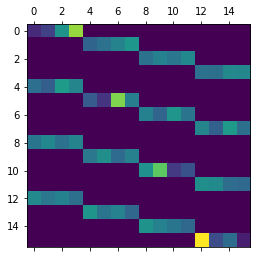

In [25]:
q_arr1 = create_q_values(M1, n_state=n_state, n_action=n_action)
q_arr2 = create_q_values(M2, n_state=n_state, n_action=n_action)
tran_mat = []
for i in range(len(q_arr1)):
    tran_vec = np.zeros((1, len(q_arr1)))
    prev_state = format(i,'b').zfill(4)[2:]
    for j in [0, 1]:
        for k in [0, 1]:
            next_state = int(prev_state + str(j) + str(k), 2)
            tran_vec[0, next_state] = softmax(q_arr2[i], beta=beta)[k] * softmax(q_arr1[i], beta=beta)[j]
    tran_mat.append(tran_vec)
tran_mat = np.concatenate(tran_mat)

plt.figure(figsize=(10, 10))
plt.matshow(tran_mat)

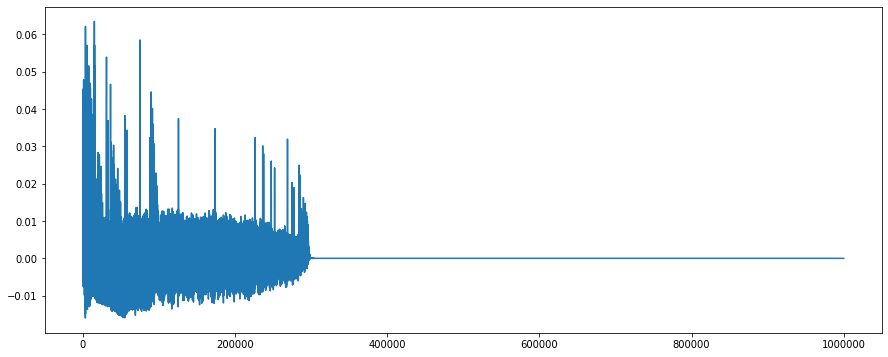

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(error_history1)), error_history1)
plt.show()

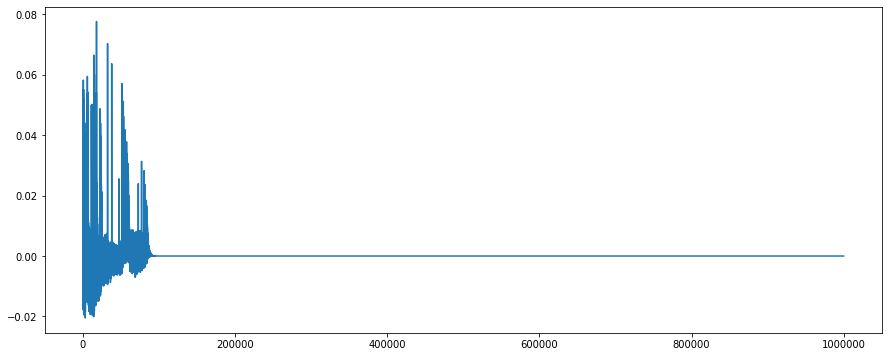

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(error_history2)), error_history2)

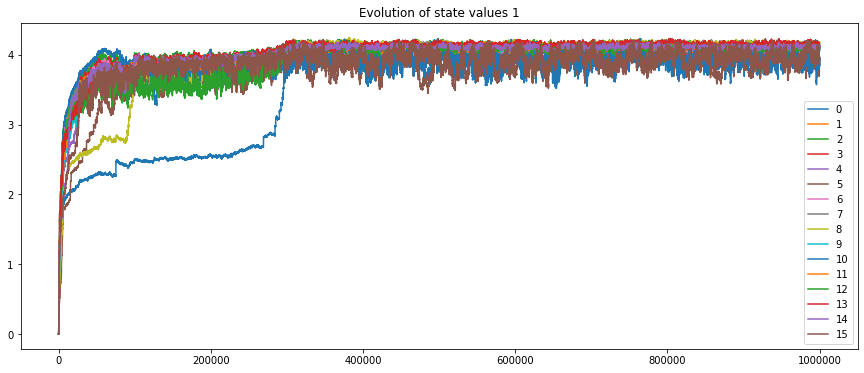

In [28]:
plt.figure(figsize=(15, 6))
for i in range(n_state):
    plt.plot(range(len(s1_mat)), s1_mat[:, i], label=str(i))
plt.title("Evolution of state values 1")
plt.legend()
plt.show()

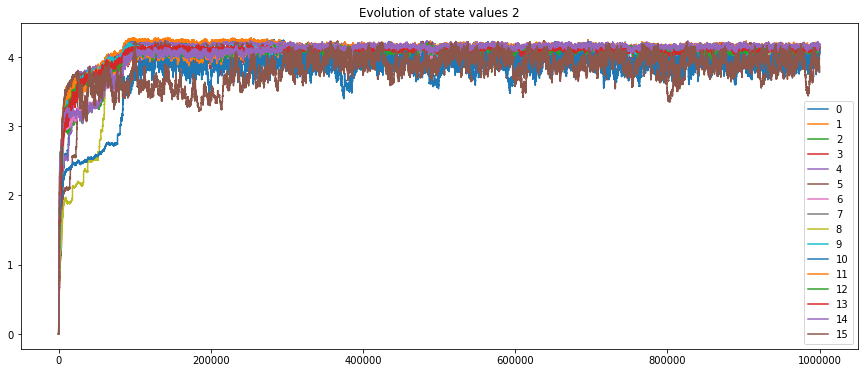

In [29]:
plt.figure(figsize=(15, 6))
for i in range(n_state):
    plt.plot(range(len(s2_mat)), s2_mat[:, i], label=str(i))
plt.title("Evolution of state values 2")
plt.legend()
plt.show()

In [30]:
game_history[-100:]

[1,
 0,
 3,
 1,
 1,
 0,
 3,
 3,
 1,
 0,
 0,
 1,
 3,
 2,
 0,
 2,
 2,
 0,
 1,
 3,
 3,
 2,
 2,
 1,
 0,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 1,
 0,
 3,
 1,
 1,
 0,
 2,
 1,
 3,
 0,
 1,
 2,
 3,
 3,
 0,
 1,
 2,
 2,
 1,
 0,
 1,
 0,
 2,
 2,
 3,
 1,
 0,
 1,
 3,
 3,
 0,
 3,
 1,
 2,
 0,
 3,
 1,
 3,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 3,
 1,
 0,
 3,
 0,
 0,
 1,
 0,
 3,
 2,
 0,
 1,
 2,
 3,
 3,
 2,
 2]

# N = 3

## SR Empowerment vs TFT

In [38]:
game_history = []
error_history = []
memory = []
num_memory = 3
n_games = 100000

lr = 0.1
gamma = 0.6

beta = 1.0

n_state=4**num_memory
n_action=2

M = np.zeros((n_state*2, n_state))
M = create_initial_mat(M, n_state=n_state, n_action=n_action)

In [39]:
# a1_action = np.random.choice([0, 1], p=softmax(q_vals[tmp_obs,:], beta=1.0))

cur_obs = None
next_obs = None
cur_action = None
next_action = None
for i in range(n_games):
    ## action of agent2 (Tit for Tat)
    if i%10000 == 0:
        print("episode", i)
    if i == 0:
        a2_action = 0 ## c
    else:
        a2_action = memory[-1][0]
    ## action of agent1
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q_vals = create_q_values(M, n_state=4**num_memory, n_action=2)
        a1_action = np.random.choice([0, 1], p=softmax(q_vals[cur_obs,:], beta=beta))
#         if i > 1000:
#             a1_action = np.random.choice([0, 1], p=softmax(q_vals[cur_obs,:], beta=beta))
#         else:
#             a1_action = np.random.randint(0, 2)
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        if i > 100:
            current_act_idx = 2*cur_obs+a1_action
            next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
            next_sr_vec = compute_mean_action_sr(M, next_obs, n_state=n_state, n_action=2)
            td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M[current_act_idx, :]
            error_history.append(np.mean(td_err))
            M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
    game_history.append(a1_action+(2*a2_action))

episode 0
episode 10000
episode 20000
episode 30000
episode 40000
episode 50000
episode 60000
episode 70000
episode 80000
episode 90000


<Figure size 432x288 with 0 Axes>

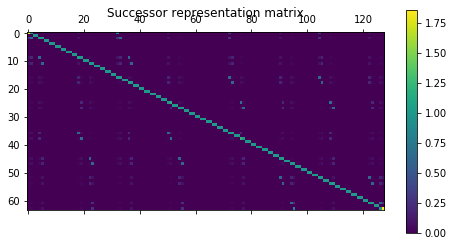

In [40]:
plt.figure()
plt.matshow(M.T)
plt.colorbar()
plt.title("Successor representation matrix")
plt.show()

In [43]:
q_arr = create_q_values(M, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(6), softmax(q_arr[i], beta=beta), s_vals[i])

000000 [0.07724405 0.92275595] 3.1003149973144675
000001 [0.5 0.5] 0.0
000010 [0.47992772 0.52007228] 4.257801897965184
000011 [0.5 0.5] 0.0
000100 [0.5 0.5] 0.0
000101 [0.5 0.5] 0.0
000110 [0.5 0.5] 0.0
000111 [0.5 0.5] 0.0
001000 [0.5 0.5] 0.0
001001 [0.46795046 0.53204954] 4.126447607349702
001010 [0.5 0.5] 0.0
001011 [0.52310705 0.47689295] 4.203788684094154
001100 [0.5 0.5] 0.0
001101 [0.5 0.5] 0.0
001110 [0.5 0.5] 0.0
001111 [0.5 0.5] 0.0
010000 [0.3485701 0.6514299] 3.969770215905614
010001 [0.5 0.5] 0.0
010010 [0.46450568 0.53549432] 4.180446709264986
010011 [0.5 0.5] 0.0
010100 [0.5 0.5] 0.0
010101 [0.5 0.5] 0.0
010110 [0.5 0.5] 0.0
010111 [0.5 0.5] 0.0
011000 [0.5 0.5] 0.0
011001 [0.65042976 0.34957024] 3.957292681871724
011010 [0.5 0.5] 0.0
011011 [0.50765191 0.49234809] 4.126433862816768
011100 [0.5 0.5] 0.0
011101 [0.5 0.5] 0.0
011110 [0.5 0.5] 0.0
011111 [0.5 0.5] 0.0
100000 [0.5 0.5] 0.0
100001 [0.5 0.5] 0.0
100010 [0.5 0.5] 0.0
100011 [0.5 0.5] 0.0
100100 [0.49235001 0.

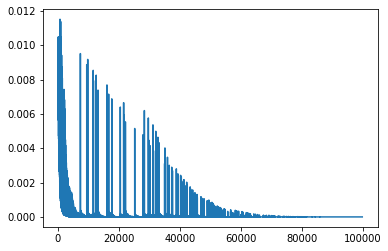

In [42]:
plt.plot(range(len(error_history)), error_history)

In [ ]:
tran_mat = []
for i in range(len(q_arr)):
    tran_vec = np.zeros((1, len(q_arr)))
    prev_state = format(i,'b').zfill(6)[2:]
    for j in [0, 1]:
        k = int(prev_state[0])
        next_state = int(prev_state + str(j) + str(k), 2)
        tran_vec[0, next_state] = softmax(q_arr[i], beta=beta)[j]
    tran_mat.append(tran_vec)
tran_mat = np.concatenate(tran_mat)

plt.figure(figsize=(10, 10))
plt.matshow(tran_mat)

## SR Empowerment vs SR Empowerment

In [109]:
game_history = []
error_history1 = []
error_history2 = []
memory = []
num_memory = 3
n_games = 1000000

lr = 0.1
gamma = 0.6

beta = 2.0

n_state=4**num_memory
n_action=2

M1 = np.zeros((n_state*2, n_state))
M1 = create_initial_mat(M1, n_state=n_state, n_action=n_action)
M2 = np.zeros((n_state*2, n_state))
M2 = create_initial_mat(M2, n_state=n_state, n_action=n_action)

In [110]:
cur_obs = None
next_obs = None
cur_action = None
next_action = None
s1_mat = []
s2_mat = []
for i in range(n_games):
    if i%10000 == 0:
        print("episode", i)
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        a2_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q1_vals = create_q_values(M1, n_state=4**num_memory, n_action=2)
        q2_vals = create_q_values(M2, n_state=4**num_memory, n_action=2)
        s1_mat.append(np.mean(q1_vals, axis=1).reshape(1, -1))
        s2_mat.append(np.mean(q2_vals, axis=1).reshape(1, -1))
        a1_action = np.random.choice([0, 1], p=softmax(q1_vals[cur_obs,:], beta=beta))
        a2_action = np.random.choice([0, 1], p=softmax(q2_vals[cur_obs,:], beta=beta))
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        if i > 100:
            ## M1
            current_act_idx = 2*cur_obs+a1_action
            next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
            next_sr_vec = compute_mean_action_sr(M1, next_obs, n_state=n_state, n_action=2)
            td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M1[current_act_idx, :]
            error_history1.append(np.mean(td_err))
            M1[current_act_idx, :] = M1[current_act_idx, :] + lr*td_err
            ## M2
            current_act_idx = 2*cur_obs+a2_action
            next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
            next_sr_vec = compute_mean_action_sr(M2, next_obs, n_state=n_state, n_action=2)
            td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M2[current_act_idx, :]
            error_history2.append(np.mean(td_err))
            M2[current_act_idx, :] = M2[current_act_idx, :] + lr*td_err
    game_history.append(a1_action+(2*a2_action))
s1_mat = np.concatenate(s1_mat, axis=0)
s2_mat = np.concatenate(s2_mat, axis=0)

episode 0
episode 10000
episode 20000
episode 30000
episode 40000
episode 50000
episode 60000
episode 70000
episode 80000
episode 90000
episode 100000
episode 110000
episode 120000
episode 130000
episode 140000
episode 150000
episode 160000
episode 170000
episode 180000
episode 190000
episode 200000
episode 210000
episode 220000
episode 230000
episode 240000
episode 250000
episode 260000
episode 270000
episode 280000
episode 290000
episode 300000
episode 310000
episode 320000
episode 330000
episode 340000
episode 350000
episode 360000
episode 370000
episode 380000
episode 390000
episode 400000
episode 410000
episode 420000
episode 430000
episode 440000
episode 450000
episode 460000
episode 470000
episode 480000
episode 490000
episode 500000
episode 510000
episode 520000
episode 530000
episode 540000
episode 550000
episode 560000
episode 570000
episode 580000
episode 590000
episode 600000
episode 610000
episode 620000
episode 630000
episode 640000
episode 650000
episode 660000
episode 6

<Figure size 432x288 with 0 Axes>

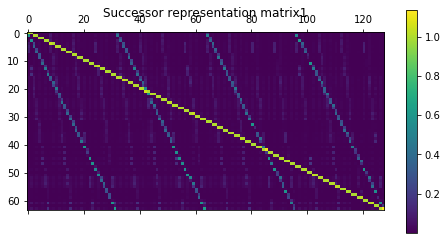

<Figure size 432x288 with 0 Axes>

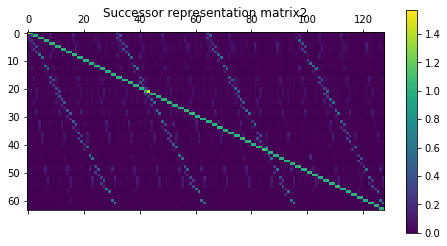

In [111]:
plt.figure()
plt.matshow(M1.T)
plt.colorbar()
plt.title("Successor representation matrix1")
plt.show()

plt.figure()
plt.matshow(M2.T)
plt.colorbar()
plt.title("Successor representation matrix2")
plt.show()

In [112]:
q_arr = create_q_values(M1, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(6), softmax(q_arr[i], beta=beta), s_vals[i])

000000 [0.55848409 0.44151591] 4.045700402356596
000001 [0.56712613 0.43287387] 4.082125635648936
000010 [0.86232159 0.13767841] 3.722559166661306
000011 [0.8117309 0.1882691] 3.7948208996942183
000100 [0.59134613 0.40865387] 3.9697562051242645
000101 [0.54028536 0.45971464] 4.0755621645358
000110 [0.7046716 0.2953284] 3.9483747111947705
000111 [0.82672112 0.17327888] 3.750365143885692
001000 [0.66046523 0.33953477] 4.030933923769183
001001 [0.58398623 0.41601377] 4.0711125484940665
001010 [0.99897171 0.00102829] 2.478765938088529
001011 [0.95240773 0.04759227] 3.41825611820943
001100 [0.78164846 0.21835154] 3.858394975140016
001101 [0.58032824 0.41967176] 4.083573329603285
001110 [0.99575822 0.00424178] 2.816046931155433
001111 [0.96365237 0.03634763] 3.2863269563865813
010000 [0.61400929 0.38599071] 4.050410694102958
010001 [0.50287791 0.49712209] 4.025188191917214
010010 [0.87657886 0.12342114] 3.667311093869187
010011 [0.82945995 0.17054005] 3.758739018896848
010100 [0.63336452 0.3

In [113]:
q_arr = create_q_values(M2, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(6), softmax(q_arr[i], beta=beta), s_vals[i])

000000 [0.04190071 0.95809929] 3.403806929533232
000001 [0.5181169 0.4818831] 4.157134315477278
000010 [0.49070513 0.50929487] 4.208410400740883
000011 [0.22533739 0.77466261] 3.9262606312019837
000100 [0.58722848 0.41277152] 4.099306168615578
000101 [0.60993227 0.39006773] 4.097080844219
000110 [0.44463322 0.55536678] 4.0668890818093235
000111 [0.34456402 0.65543598] 3.918799015335509
001000 [0.41651469 0.58348531] 4.138490936821958
001001 [0.53448255 0.46551745] 4.171468866020009
001010 [9.40483502e-04 9.99059516e-01] 2.5454889893331907
001011 [0.0598786 0.9401214] 3.6154092868717362
001100 [0.04339333 0.95660667] 3.3259154290937576
001101 [0.53425078 0.46574922] 4.208180925133584
001110 [0.50039081 0.49960919] 4.282065848400724
001111 [0.0500239 0.9499761] 3.5683651578386915
010000 [0.44645858 0.55354142] 4.079098197741121
010001 [0.48546494 0.51453506] 4.072937035312858
010010 [0.4784941 0.5215059] 4.141208924789288
010011 [0.27248816 0.72751184] 3.9884362389051105
010100 [0.532202

In [ ]:
q_arr1 = create_q_values(M1, n_state=n_state, n_action=n_action)
q_arr2 = create_q_values(M2, n_state=n_state, n_action=n_action)
tran_mat = []
for i in range(len(q_arr1)):
    tran_vec = np.zeros((1, len(q_arr1)))
    prev_state = format(i,'b').zfill(6)[2:]
    for j in [0, 1]:
        for k in [0, 1]:
            next_state = int(prev_state + str(j) + str(k), 2)
            tran_vec[0, next_state] = softmax(q_arr2[i], beta=beta)[k] * softmax(q_arr1[i], beta=beta)[j]
    tran_mat.append(tran_vec)
tran_mat = np.concatenate(tran_mat)

plt.figure(figsize=(10, 10))
plt.matshow(tran_mat)

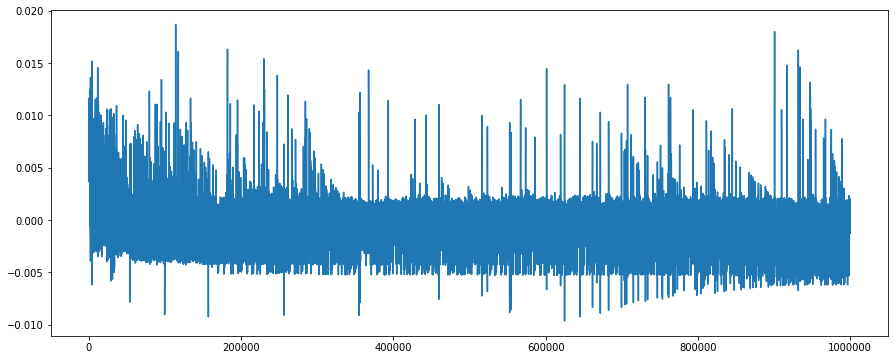

In [114]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(error_history1)), error_history1)
plt.show()

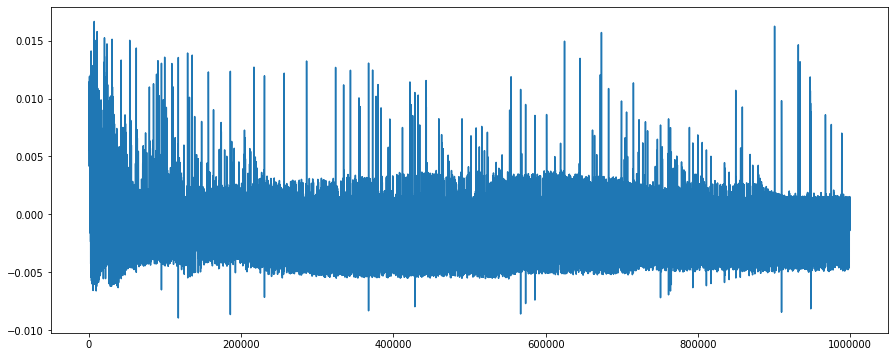

In [115]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(error_history2)), error_history2)

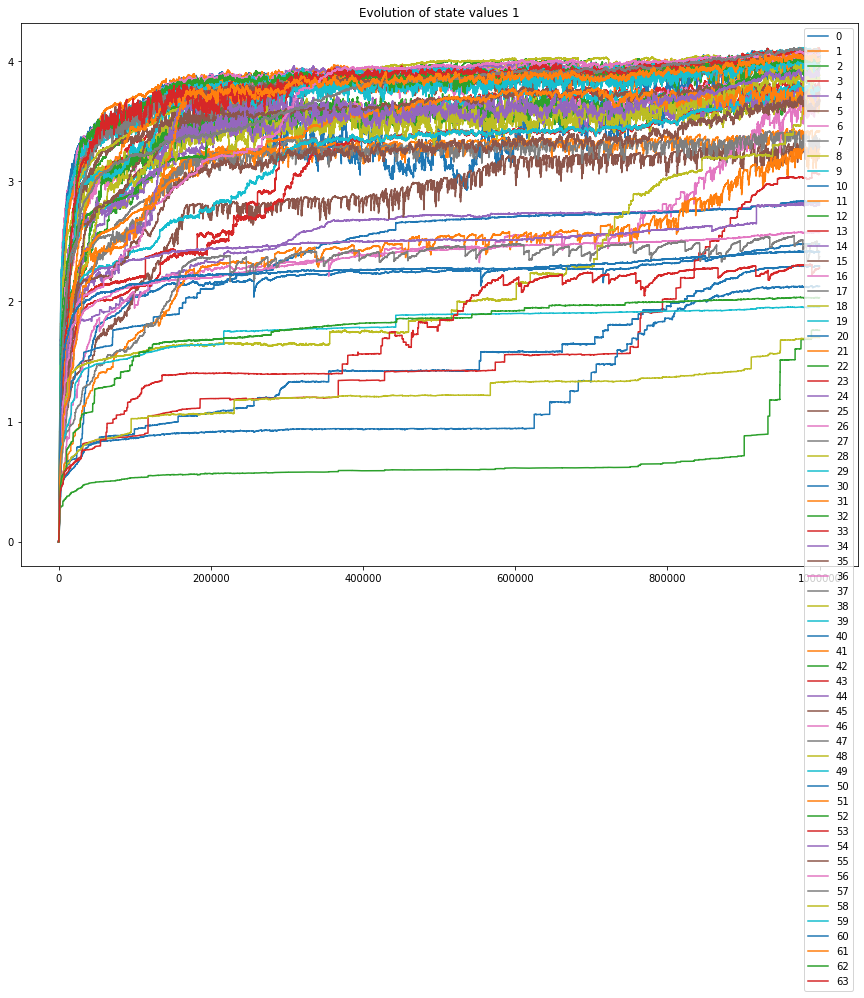

In [117]:
plt.figure(figsize=(15, 10))
for i in range(n_state):
    plt.plot(range(len(s1_mat)), s1_mat[:, i], label=str(i))
plt.title("Evolution of state values 1")
plt.legend()
plt.show()

# N = 5

## SR Empowerment vs TFT

In [9]:
game_history = []
memory = []
num_memory = 5
n_games = 1000000

lr = 0.1
gamma = 0.95
M = np.zeros(((4**num_memory)*2, 4**num_memory))
M = create_initial_mat(M)

In [10]:
cur_obs = None
next_obs = None
cur_action = None
next_action = None
for i in range(n_games):
    ## action of agent2 (Tit for Tat)
    if i%1000 == 0:
        print("episode", i)
    if i == 0:
        a2_action = 0 ## c
    else:
        a2_action = memory[-1][0]
    ## action of agent1
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q_vals = create_q_values(M, n_state=4**num_memory, n_action=2)
        if i > 10000:
            a1_action = np.argmax(q_vals[cur_obs,:])
        else:
            a1_action = np.random.randint(0, 2)
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        current_act_idx = 2*cur_obs+a1_action
        next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        next_sr_vec = compute_mean_action_sr(M, next_obs, n_state=4**num_memory, n_action=2)
        td_err = np.eye(4**num_memory)[cur_obs] + gamma*next_sr_vec - M[current_act_idx, :]
        M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
    game_history.append(a1_action+(2*a2_action))

episode 0
episode 1000
episode 2000
episode 3000
episode 4000
episode 5000
episode 6000
episode 7000
episode 8000
episode 9000
episode 10000


KeyboardInterrupt: 

In [16]:
game_history[10000:]

[2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 0,
 0,


<Figure size 432x288 with 0 Axes>

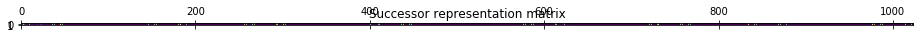

[[2.81057815 0.03875614 0.81294193 ... 0.01932454 0.         0.01817829]
 [1.02105587 0.01394903 0.9546418  ... 0.03202052 0.         0.03002193]
 [1.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04137714 0.01155476 0.02720411 ... 0.9628091  0.         1.01552997]
 [0.02037151 0.00699162 0.01191328 ... 0.77064098 0.         2.67577441]]


In [22]:
plt.figure()
plt.matshow(create_q_values(M, n_state=4**num_memory, n_action=2).T)
plt.title("Successor representation matrix")
plt.show()
print(M)

## Empowerment vs Empowerment

In [1]:
create_q_values(M, n_state=4**num_memory, n_action=2)[:100]

NameError: name 'create_q_values' is not defined